In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# model and its preprocessing function
from tensorflow.keras.applications import Xception, InceptionV3, MobileNetV2
from tensorflow.keras.applications.xception import preprocess_input 

# reading images
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import img_to_array

# imagenet utils
from tensorflow.keras.applications.imagenet_utils import decode_predictions

#reading images
from tensorflow.keras.utils import load_img, img_to_array
from keras.utils import to_categorical

# loss
from tensorflow.keras.losses import CategoricalCrossentropy, MeanSquaredError

import glob, os

# for measuring similarity of weights
from sklearn.metrics.pairwise import cosine_similarity

import pandas as pd

from sklearn.metrics import accuracy_score, confusion_matrix

import seaborn as sns


In [2]:
# class_mapping_dic = {0:559, 1:545, 2:736, 3:412, 4:571, 5:894, 7:518, 8:561, 9:898}
class_mapping_dic = {1:545, 3:412, 4:571, 8:561, 9: 478}

df1 = pd.read_csv('MOBILE_NET_V1_labeling.csv')

In [3]:
df1

,id,image_name,aruco_id,class_id1,class_id2,class_id3,class_id4,class_id5
0,0,0.jpg,8,583,561,707,867,675
1,1,1.jpg,8,583,561,707,856,648
2,2,2.jpg,8,561,583,856,867,595
3,3,3.jpg,8,561,583,856,600,648
4,4,4.jpg,8,561,583,856,600,517
...,...,...,...,...,...,...,...,...
89,89,89.jpg,8,583,867,561,844,705
90,90,90.jpg,8,561,867,583,675,811
91,91,91.jpg,8,867,561,583,675,811
92,92,92.jpg,8,561,867,583,675,705


In [4]:
# these functions can be used to read an original img and create a single adversarial sample, as well as to read and create two datasets from adirectory: 
# with clear and adversarial samples + its true labels
def read_img(filename, size, preprocess_function):
    img = load_img(filename, target_size=size)
    img_array = img_to_array(img)
    img_array_original = preprocess_function(img_array)
    return img_array_original

def create_dataset(main_folder_path, size, preprocess_function, class_dictionary, df_name):
    X_adversarial = []
    X_original = []
    y = []
    preds = []
    known_classes = class_mapping_dic.values()
    os.chdir(".")
    for file in glob.glob(main_folder_path + "/*.jpg"):
        img_label = file.split('\\')[1]
#         print(img_label)
        aruco_id = df_name.loc[df_name.image_name == img_label].aruco_id.values[0]
        if aruco_id in class_dictionary:
            label = class_dictionary[aruco_id]
            pred = df_name.loc[df_name.image_name == img_label].class_id1.values[0]
            img = read_img(filename=file, size=size, preprocess_function=preprocess_function)
            y.append(label)
            X_original.append(img)
            if pred in known_classes:
                preds.append(pred)
            else:
                preds.append(-1)
        else:
            continue
    y = np.asarray(y)
    X_original = np.asarray(X_original)
    preds = np.asarray(preds)
    return X_original, y, preds


In [5]:
sns.set(font_scale=1.3)

0.425531914893617


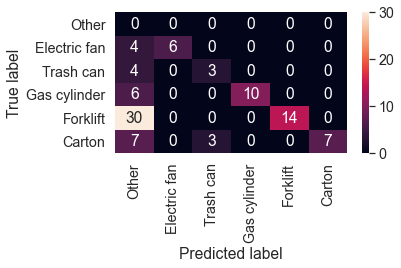

0.425531914893617


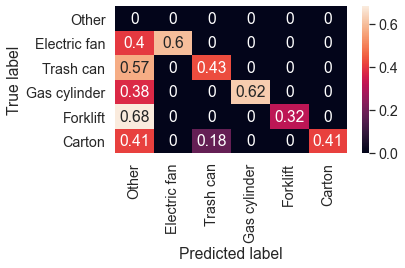

In [6]:
X, y, preds = create_dataset('./', size=(224,224), preprocess_function=preprocess_input, 
                             class_dictionary=class_mapping_dic, df_name=df1)


conf_mat = confusion_matrix(y, preds, labels=[-1] + list(class_mapping_dic.values()))
print(accuracy_score(y, preds))

categories = ['Other',
                'Electric fan',
                'Trash can',
                'Gas cylinder',
                'Forklift',
                 'Carton']

sns.heatmap(conf_mat, annot=True, xticklabels=categories, yticklabels=categories)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
folder_name = os.getcwd().split('\\')[-1]
main_folder = 'results\\'
plt.savefig(f"{main_folder}MobileNet_{folder_name}.jpg", dpi=500)
plt.show()

conf_mat = confusion_matrix(y, preds, labels=[-1] + list(class_mapping_dic.values()), normalize='true')
print(accuracy_score(y, preds))

categories = ['Other',
                'Electric fan',
                'Trash can',
                'Gas cylinder',
                'Forklift',
                 'Carton']

sns.heatmap(conf_mat, annot=True, xticklabels=categories, yticklabels=categories)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
folder_name = os.getcwd().split('\\')[-1]
main_folder = 'results\\'
plt.savefig(f"{main_folder}MobileNet_{folder_name}_norm.jpg", dpi=500)
plt.show()

3/3 [==============================] - 7s 2s/step
0.6382978723404256


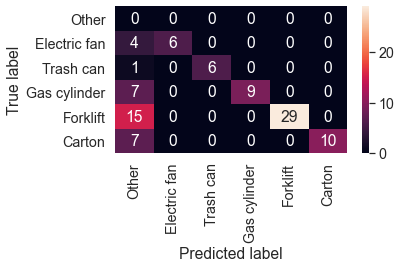

0.6382978723404256


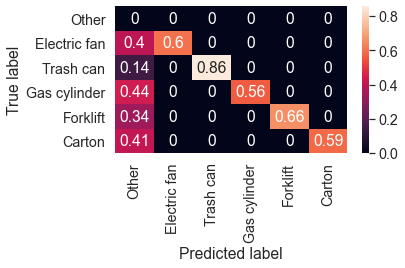

In [7]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input 

model = Xception(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

X, y, preds = create_dataset('./', size=(299,299), preprocess_function=preprocess_input, 
                             class_dictionary=class_mapping_dic, df_name=df1)

preds_offline = model.predict(X)
preds_offline = np.argmax(preds_offline, axis=1)

print(accuracy_score(y, preds_offline))

known_classes = class_mapping_dic.values()

for i in range(0, len(preds_offline)):
    if preds_offline[i] in list(known_classes):
        continue
    else:
        preds_offline[i] = -1

conf_mat = confusion_matrix(y, preds_offline, labels=[-1] + list(class_mapping_dic.values()))

categories = ['Other',
                'Electric fan',
                'Trash can',
                'Gas cylinder',
                'Forklift',
                 'Carton']


sns.heatmap(conf_mat, annot=True, xticklabels=categories, yticklabels=categories)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
folder_name = os.getcwd().split('\\')[-1]
main_folder = 'results\\'
plt.savefig(f"{main_folder}{model.name}_{folder_name}.jpg", dpi=500)
plt.show()

conf_mat = confusion_matrix(y, preds_offline, labels=[-1] + list(class_mapping_dic.values()), normalize='true')
print(accuracy_score(y, preds_offline))

categories = ['Other',
                'Electric fan',
                'Trash can',
                'Gas cylinder',
                'Forklift',
                 'Carton']

sns.heatmap(conf_mat, annot=True, xticklabels=categories, yticklabels=categories)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
folder_name = os.getcwd().split('\\')[-1]
main_folder = 'results\\'
plt.savefig(f"{main_folder}{model.name}_{folder_name}_norm.jpg", dpi=500)
plt.show()

3/3 [==============================] - 5s 1s/step
0.648936170212766


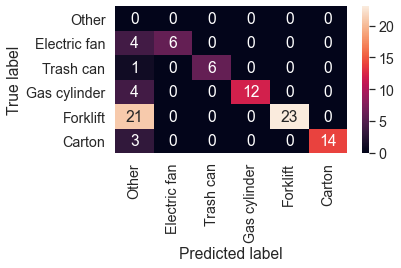

0.648936170212766


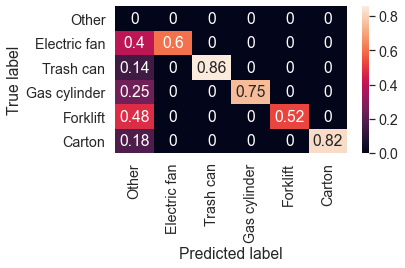

In [8]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input 

model = InceptionV3(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

X, y, preds = create_dataset('./', size=(299,299), preprocess_function=preprocess_input, 
                             class_dictionary=class_mapping_dic, df_name=df1)

preds_offline = model.predict(X)
preds_offline = np.argmax(preds_offline, axis=1)

print(accuracy_score(y, preds_offline))

known_classes = class_mapping_dic.values()

for i in range(0, len(preds_offline)):
    if preds_offline[i] in list(known_classes):
        continue
    else:
        preds_offline[i] = -1

conf_mat = confusion_matrix(y, preds_offline, labels=[-1] + list(class_mapping_dic.values()))

categories = ['Other',
                'Electric fan',
                'Trash can',
                'Gas cylinder',
                'Forklift',
                 'Carton']


sns.heatmap(conf_mat, annot=True, xticklabels=categories, yticklabels=categories)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
folder_name = os.getcwd().split('\\')[-1]
main_folder = 'results\\'
plt.savefig(f"{main_folder}{model.name}_{folder_name}.jpg", dpi=500)
plt.show()

conf_mat = confusion_matrix(y, preds_offline, labels=[-1] + list(class_mapping_dic.values()), normalize='true')
print(accuracy_score(y, preds_offline))

categories = ['Other',
                'Electric fan',
                'Trash can',
                'Gas cylinder',
                'Forklift',
                 'Carton']

sns.heatmap(conf_mat, annot=True, xticklabels=categories, yticklabels=categories)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
folder_name = os.getcwd().split('\\')[-1]
main_folder = 'results\\'
plt.savefig(f"{main_folder}{model.name}_{folder_name}_norm.jpg", dpi=500)
plt.show()

3/3 [==============================] - 2s 334ms/step
0.5


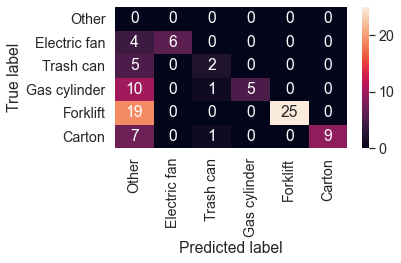

0.5


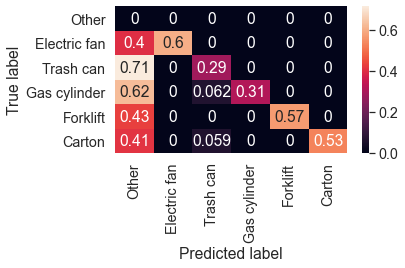

In [9]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input 

model = MobileNetV2(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

X, y, preds = create_dataset('./', size=(224,224), preprocess_function=preprocess_input, 
                             class_dictionary=class_mapping_dic, df_name=df1)

preds_offline = model.predict(X)
preds_offline = np.argmax(preds_offline, axis=1)

print(accuracy_score(y, preds_offline))

known_classes = class_mapping_dic.values()

for i in range(0, len(preds_offline)):
    if preds_offline[i] in list(known_classes):
        continue
    else:
        preds_offline[i] = -1

conf_mat = confusion_matrix(y, preds_offline, labels=[-1] + list(class_mapping_dic.values()))

categories = ['Other',
                'Electric fan',
                'Trash can',
                'Gas cylinder',
                'Forklift',
                 'Carton']


sns.heatmap(conf_mat, annot=True, xticklabels=categories, yticklabels=categories)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
folder_name = os.getcwd().split('\\')[-1]
main_folder = 'results\\'
plt.savefig(f"{main_folder}{model.name}_{folder_name}.jpg", dpi=500)
plt.show()

conf_mat = confusion_matrix(y, preds_offline, labels=[-1] + list(class_mapping_dic.values()), normalize='true')
print(accuracy_score(y, preds_offline))

categories = ['Other',
                'Electric fan',
                'Trash can',
                'Gas cylinder',
                'Forklift',
                 'Carton']

sns.heatmap(conf_mat, annot=True, xticklabels=categories, yticklabels=categories)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
folder_name = os.getcwd().split('\\')[-1]
main_folder = 'results\\'
plt.savefig(f"{main_folder}{model.name}_{folder_name}_norm.jpg", dpi=500)
plt.show()

3/3 [==============================] - 5s 1s/step
0.6808510638297872


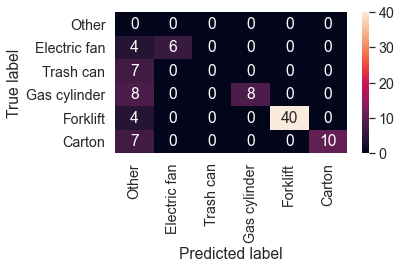

0.6808510638297872


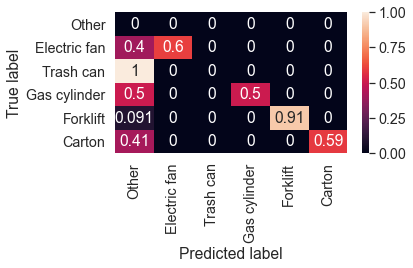

In [10]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input 

model = ResNet50(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

X, y, preds = create_dataset('./', size=(224,224), preprocess_function=preprocess_input, 
                             class_dictionary=class_mapping_dic, df_name=df1)

preds_offline = model.predict(X)
preds_offline = np.argmax(preds_offline, axis=1)

print(accuracy_score(y, preds_offline))

known_classes = class_mapping_dic.values()

for i in range(0, len(preds_offline)):
    if preds_offline[i] in list(known_classes):
        continue
    else:
        preds_offline[i] = -1

conf_mat = confusion_matrix(y, preds_offline, labels=[-1] + list(class_mapping_dic.values()))

categories = ['Other',
                'Electric fan',
                'Trash can',
                'Gas cylinder',
                'Forklift',
                 'Carton']


sns.heatmap(conf_mat, annot=True, xticklabels=categories, yticklabels=categories)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
folder_name = os.getcwd().split('\\')[-1]
main_folder = 'results\\'
plt.savefig(f"{main_folder}{model.name}_{folder_name}.jpg", dpi=500)
plt.show()

conf_mat = confusion_matrix(y, preds_offline, labels=[-1] + list(class_mapping_dic.values()), normalize='true')
print(accuracy_score(y, preds_offline))

categories = ['Other',
                'Electric fan',
                'Trash can',
                'Gas cylinder',
                'Forklift',
                 'Carton']

sns.heatmap(conf_mat, annot=True, xticklabels=categories, yticklabels=categories)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
folder_name = os.getcwd().split('\\')[-1]
main_folder = 'results\\'
plt.savefig(f"{main_folder}{model.name}_{folder_name}_norm.jpg", dpi=500)
plt.show()

3/3 [==============================] - 9s 2s/step
0.6170212765957447


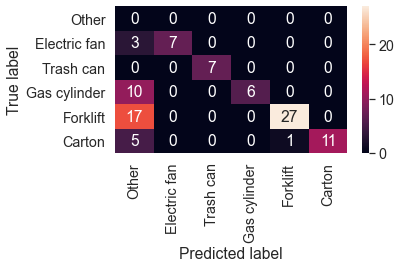

0.6170212765957447


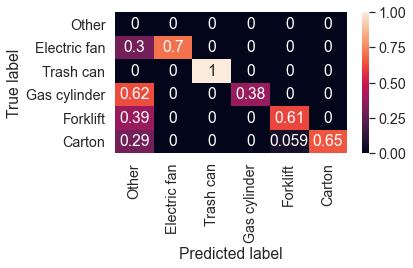

In [11]:
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.resnet import preprocess_input 

model = ResNet101(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

X, y, preds = create_dataset('./', size=(224,224), preprocess_function=preprocess_input, 
                             class_dictionary=class_mapping_dic, df_name=df1)

preds_offline = model.predict(X)
preds_offline = np.argmax(preds_offline, axis=1)

print(accuracy_score(y, preds_offline))

known_classes = class_mapping_dic.values()

for i in range(0, len(preds_offline)):
    if preds_offline[i] in list(known_classes):
        continue
    else:
        preds_offline[i] = -1

conf_mat = confusion_matrix(y, preds_offline, labels=[-1] + list(class_mapping_dic.values()))

categories = ['Other',
                'Electric fan',
                'Trash can',
                'Gas cylinder',
                'Forklift',
                 'Carton']


sns.heatmap(conf_mat, annot=True, xticklabels=categories, yticklabels=categories)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
folder_name = os.getcwd().split('\\')[-1]
main_folder = 'results\\'
plt.savefig(f"{main_folder}{model.name}_{folder_name}.jpg", dpi=500)
plt.show()

conf_mat = confusion_matrix(y, preds_offline, labels=[-1] + list(class_mapping_dic.values()), normalize='true')
print(accuracy_score(y, preds_offline))

categories = ['Other',
                'Electric fan',
                'Trash can',
                'Gas cylinder',
                'Forklift',
                 'Carton']

sns.heatmap(conf_mat, annot=True, xticklabels=categories, yticklabels=categories)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
folder_name = os.getcwd().split('\\')[-1]
main_folder = 'results\\'
plt.savefig(f"{main_folder}{model.name}_{folder_name}_norm.jpg", dpi=500)
plt.show()

3/3 [==============================] - 7s 2s/step
0.5106382978723404


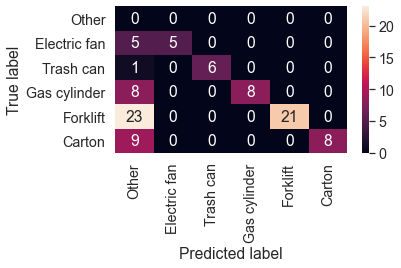

0.5106382978723404


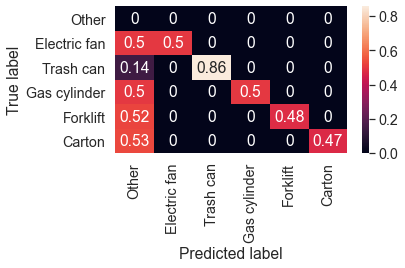

In [12]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input 

model = DenseNet121(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

X, y, preds = create_dataset('./', size=(224,224), preprocess_function=preprocess_input, 
                             class_dictionary=class_mapping_dic, df_name=df1)

preds_offline = model.predict(X)
preds_offline = np.argmax(preds_offline, axis=1)

print(accuracy_score(y, preds_offline))

known_classes = class_mapping_dic.values()

for i in range(0, len(preds_offline)):
    if preds_offline[i] in list(known_classes):
        continue
    else:
        preds_offline[i] = -1

conf_mat = confusion_matrix(y, preds_offline, labels=[-1] + list(class_mapping_dic.values()))

categories = ['Other',
                'Electric fan',
                'Trash can',
                'Gas cylinder',
                'Forklift',
                 'Carton']


sns.heatmap(conf_mat, annot=True, xticklabels=categories, yticklabels=categories)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
folder_name = os.getcwd().split('\\')[-1]
main_folder = 'results\\'
plt.savefig(f"{main_folder}{model.name}_{folder_name}.jpg", dpi=500)
plt.show()

conf_mat = confusion_matrix(y, preds_offline, labels=[-1] + list(class_mapping_dic.values()), normalize='true')
print(accuracy_score(y, preds_offline))

categories = ['Other',
                'Electric fan',
                'Trash can',
                'Gas cylinder',
                'Forklift',
                 'Carton']

sns.heatmap(conf_mat, annot=True, xticklabels=categories, yticklabels=categories)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
folder_name = os.getcwd().split('\\')[-1]
main_folder = 'results\\'
plt.savefig(f"{main_folder}{model.name}_{folder_name}_norm.jpg", dpi=500)
plt.show()